In [2]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [3]:
# global constants
Sv=1.e9 # m^3/sec

In [7]:
# salinity only, linear forcing 
input_data = np.load('data/input_sal_temp_ns.npy')[:, 1:]
output_data = np.load('data/output_sal_temp_ns.npy')

In [9]:
X_train = input_data[0:75000]
y_train = output_data[0:75000]
X_val = input_data[75000:90000]
y_val = output_data[75000:90000]
X_test = input_data[90000:100000]
y_test = output_data[90000:100000] 

In [10]:
y_train.shape

(75000,)

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)
output_scaled = keras.utils.to_categorical(output_data)

In [12]:
# sequences to input into LSTM 
def create_sequences(input_data, output_data, time_steps):
    input_sequences, output_sequences = [], []
    for i in range(len(input_data) - time_steps + 1):
        input_sequences.append(input_data[i:i + time_steps])
        output_sequences.append(output_data[i + time_steps - 1]) 
    return np.array(input_sequences), np.array(output_sequences)

time_steps = 10
feature_dim = 4

X_train_seq, y_train_seq = create_sequences(X_train_scaled, Y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, Y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, Y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_scaled, time_steps)

print("Input shape:", X_val_seq.shape)  
print("Output shape:", y_train_seq.shape) 


Input shape: (14991, 10, 4)
Labels shape: (74991, 2)


In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Example: Input data dimensions
time_steps = 10  # Number of sequential vectors
feature_dim = 4  # Each vector has 5 features
batch_size = 32  # Batch size

# Generate dummy data for demonstration
# Input shape: (number of samples, time_steps, feature_dim)
#X_train = np.random.rand(1000, time_steps, feature_dim)
#y_train = np.random.randint(0, 2, size=(1000, 1))  # Binary labels (0 or 1)

#X_test = np.random.rand(200, time_steps, feature_dim)
#y_test = np.random.randint(0, 2, size=(200, 1))

# Build the LSTM model
model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  # LSTM layer
    Dense(4, activation='relu'),  # Optional dense layer for additional learning
    Dense(2, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model_eval = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), 
          epochs=10, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/10
2344/2344 [==============================] - 11s 4ms/step - loss: 0.1947 - accuracy: 0.9962 - val_loss: 0.0829 - val_accuracy: 0.9996
Epoch 2/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0484 - accuracy: 0.9995 - val_loss: 0.0268 - val_accuracy: 0.9995
Epoch 3/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0168 - accuracy: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9997
Epoch 4/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0067 - accuracy: 0.9997 - val_loss: 0.0042 - val_accuracy: 0.9997
Epoch 5/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 6/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 7/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 6.9209e-04 - val_accu

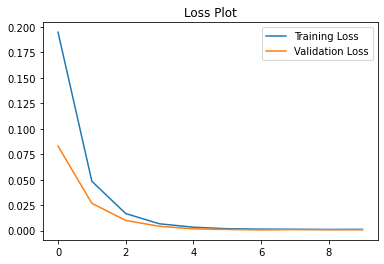

In [15]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [16]:
input_seq, output_seq = create_sequences(input_scaled, output_scaled, time_steps)

In [17]:
y_pred_all = model.predict(input_seq)

3125/3125 [==============================] - 5s 2ms/step


In [18]:
y_labels_all = np.argmax(y_pred_all, axis=-1)

In [19]:
false_indices_sal_temp_sine = []
for i in range(len(y_labels_all)):
    if y_labels_all[i] != output_data[i]:
        false_indices_sal_temp_sine.append(i)

In [20]:
qplot = np.load('data/q_sal_temp_ns.npy')

In [22]:
qplot.shape

(100000,)

In [23]:
time = np.load('data/input_sal_temp_ns.npy')[:, 0]

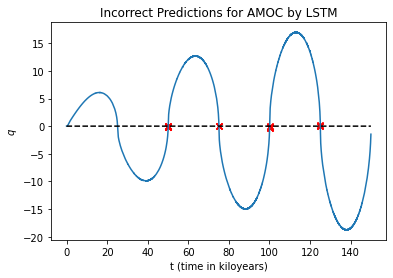

In [27]:
plt.plot(time, qplot/Sv);
plt.plot(time, input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC by LSTM');
plt.scatter([time[i] for i in false_indices_sal_temp_sine], [qplot[i]/Sv for i in false_indices_sal_temp_sine], marker='x', c='red');
plt.savefig('predictions_lstm_ns', dpi=200)

In [25]:
model.save('lstm_wo_time.h5')

/Applications/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_scaled, Y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, Y_val),
                    callbacks=[es])#,
    os.makedirs("models_nonrandom", exist_ok=True)
    model.save('models_nonrandom/stommel_model_ts_sine_'+str(i)+'.h5')

0
1
2
3
4
5
6
Epoch 6: early stopping
7
8
9


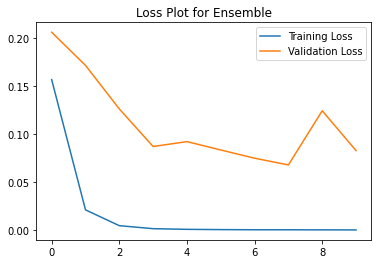

In [113]:
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot for Ensemble')
plt.legend();

In [16]:
accuracies = []

In [17]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models_nonrandom/stommel_model_ts_sine_'+str(i)+'.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, Y_test)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
1563/1563 [==============================] - 2s 939us/step - loss: 0.8756 - accuracy: 0.8970
Test loss: 0.875575840473175
Test accuracy: 0.8969600200653076
1
1563/1563 [==============================] - 1s 794us/step - loss: 0.5494 - accuracy: 0.9704
Test loss: 0.5493618249893188
Test accuracy: 0.9703999757766724
2
1563/1563 [==============================] - 1s 721us/step - loss: 0.0122 - accuracy: 0.9953
Test loss: 0.0121502336114645
Test accuracy: 0.9952800273895264
3
1563/1563 [==============================] - 1s 818us/step - loss: 0.0022 - accuracy: 0.9990
Test loss: 0.002249310491606593
Test accuracy: 0.998960018157959
4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0308 - accuracy: 0.9934
Test loss: 0.03075627237558365
Test accuracy: 0.9933800101280212
5
1563/1563 [==============================] - 1s 722us/step - loss: 0.1445 - accuracy: 0.9813
Test loss: 0.14451631903648376
Test accuracy: 0.9813200235366821
6
1563/1563 [==============================] -

In [18]:
sum(accuracies)/10*100

96.96300029754639

In [8]:
datapredicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 2))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models_nonrandom/stommel_model_ts_sine_'+str(i)+'.h5')
    datapredicted = model.predict(input_scaled)
    datapredicted_results_ensemble[i,...] = datapredicted

0
3125/3125 [==============================] - 2s 641us/step
1
3125/3125 [==============================] - 2s 610us/step
2
3125/3125 [==============================] - 2s 584us/step
3
3125/3125 [==============================] - 2s 589us/step
4
3125/3125 [==============================] - 2s 605us/step
5
3125/3125 [==============================] - 2s 621us/step
6
3125/3125 [==============================] - 2s 708us/step
7
3125/3125 [==============================] - 2s 635us/step
8
3125/3125 [==============================] - 2s 629us/step
9
3125/3125 [==============================] - 2s 638us/step


In [9]:
y_pred_ensemble = np.mean(datapredicted_results_ensemble, 0).argmax(axis=-1)

In [10]:
false_indices_ts_sine_ensemble = []

In [11]:
for i in range(len(y_pred_ensemble)):
    if y_pred_ensemble[i] != output_data[i]:
        false_indices_ts_sine_ensemble.append(i)

In [12]:
false_indices_ts_sine_ensemble

[33388,
 33389,
 33390,
 33391,
 33392,
 33393,
 33394,
 33395,
 33396,
 33397,
 33398,
 33399,
 33400,
 33401,
 33402,
 33403,
 33404,
 33405,
 33406,
 33407,
 33408,
 33409,
 33410,
 33411,
 33412,
 33413,
 33414,
 33415,
 33416,
 49902,
 49903,
 49904,
 49905,
 49906,
 49907,
 49908,
 49909,
 49910,
 49911,
 49912,
 49913,
 49914,
 49915,
 49916,
 49917,
 49918,
 49919,
 49920,
 49921,
 49922,
 49923,
 49924,
 49925,
 49926,
 49927,
 49928,
 49929,
 49930,
 49931,
 49932,
 49933,
 49934,
 49935,
 49936,
 49937,
 49938,
 49939,
 49940,
 49941,
 49942,
 49943,
 49944,
 49945,
 49946,
 49947,
 49948,
 49949,
 49950,
 49951,
 49952,
 49953,
 49954,
 49955,
 49956,
 49957,
 49958,
 49959,
 49960,
 49961,
 49962,
 49963,
 49964,
 49965,
 49966,
 49967,
 49968,
 49969,
 49970,
 49971,
 49972,
 49973,
 49974,
 49975,
 49976,
 49977,
 49978,
 49979,
 49980,
 49981,
 49982,
 49983,
 49984,
 49985,
 49986,
 49987,
 49988,
 49989,
 49990,
 49991,
 49992,
 49993,
 49994,
 49995,
 49996,
 49997,


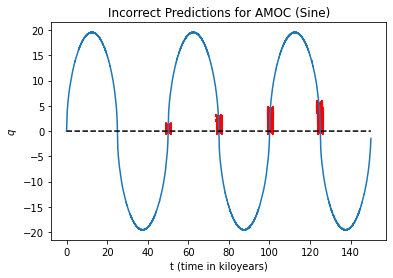

In [14]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC (Sine)');
plt.scatter([input_data[:, 0][i] for i in false_indices_ts_sine_ensemble], [qplot[i]/Sv for i in false_indices_ts_sine_ensemble], marker='x', c='red');
plt.savefig('predictions', dpi=200)